# 2. Prédiction des émissions de CO2

## 2.1. PRÉDICTION SANS FEATURE ENGINEERING

In [33]:
import numpy as np
import pandas as pd
import mytools as mt
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1.1 CHARGEMENT DES DONNÉES ET ANALYSE PRÉLIMINAIRE

Commençons par importer le dataset des prédicteurs :

In [34]:
data_light = pd.read_csv('data_light.csv')
data_light.head()

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
0,47,29,98101.0,7,14,47.61220,-122.33799,1927,0.693147,2.564949,11.390023,0.000000,11.390023,29,11.390023,48,0.000000,48,0.000000
1,47,29,98101.0,7,14,47.61317,-122.33393,1996,0.693147,2.484907,11.547974,9.620129,11.390792,29,11.337154,66,9.620129,76,8.438799
2,47,29,98101.0,7,14,47.61393,-122.33810,1969,0.693147,3.737670,13.770629,12.189532,13.540275,29,13.536450,48,0.000000,48,0.000000
3,47,29,98101.0,7,14,47.61412,-122.33664,1926,0.693147,2.397895,11.023878,0.000000,11.023878,29,11.023878,48,0.000000,48,0.000000
4,47,29,98121.0,7,14,47.61375,-122.34047,1980,0.693147,2.944439,12.075856,11.034906,11.640272,29,11.723559,66,11.127410,88,0.000000


In [35]:
data_light.shape

(1637, 19)

Importons aussi le dataset initial qui contient notre cible :

In [36]:
data = pd.read_csv('data_initial.csv')
data.shape

(1637, 32)

#### CORRÉLATIONS DES VARIABLES

Avant de commencer l'entrainement de modèles, nous allons analyser les corrélations des prédicteurs deux à deux :

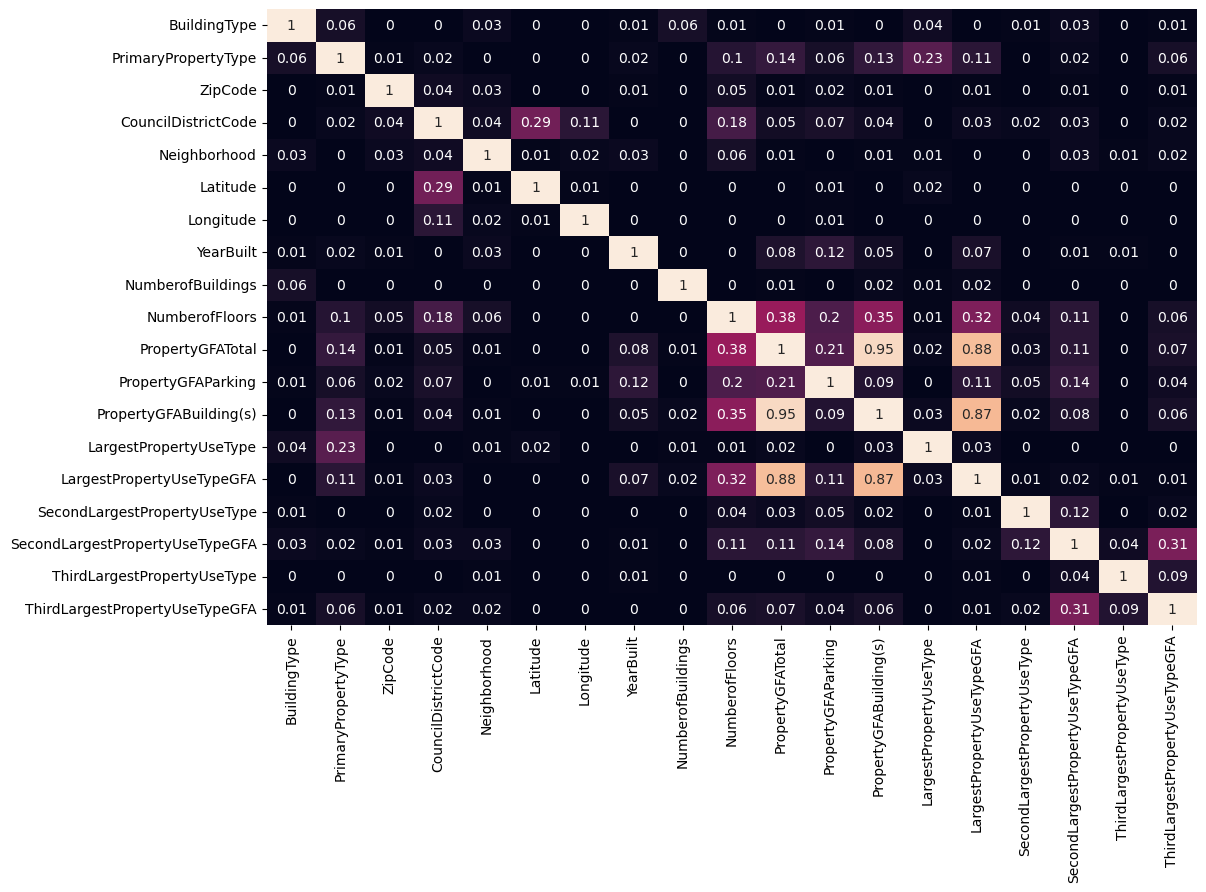

In [37]:
matrice_correlation = (data_light.corr()**2).round(2)

plt.figure(figsize = (12,8))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

On observe trois couples de variables fortement corrélées. On peut donc prévoir que la régression linéaire régularisée pourra être légèrement plus performante que la régression simple, le Ridge en regroupant les variables corrélées et le Lasso en les sélectionnant. Nous allons maintenant analyser les corrélations des prédicteurs avec la cible.

In [38]:
y = data.TotalGHGEmissions              # La cible

In [39]:
mt.stats(y.to_frame())

,count,mean,std,min,25%,50%,75%,max
TotalGHGEmissions,1637.0,133.049,235.32,0.12,20.1,49.53,142.36,2451.58


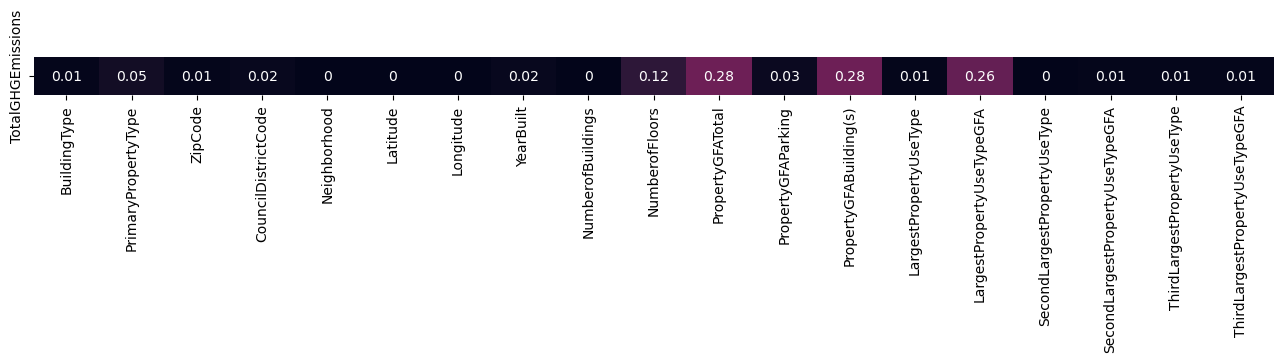

In [40]:
matrice_correlation = ((pd.concat([data_light, y], axis=1).corr()**2).round(2)).iloc[-1:,:-1]

plt.figure(figsize = (16,0.5))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

Il n'y a pas de variable fortement corrélée à la cible ni d'écarts importants entre les coefficients de corrélation. Donc la plupart des variables auront des poids du même ordre de grandeur dans la régression linéaire (avec les prédicteurs normalisés).

#### NORMALISATION DES PRÉDICTEURS

Nous allons normaliser les prédicteurs afin qu'ils aient une amplitude comparable. Nous allons utiliser le MinMaxScaler qui force l'amplitude des variables entre 0 et 1 :

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_light)
scaled_data = pd.DataFrame(scaled_data, columns=data_light.columns)
mt.stats_extend(scaled_data)[['min','max']]

,min,max
BuildingType,0.0,1.0
PrimaryPropertyType,0.0,1.0
ZipCode,0.0,1.0
CouncilDistrictCode,0.0,1.0
Neighborhood,0.0,1.0
Latitude,0.0,1.0
Longitude,0.0,1.0
YearBuilt,0.0,1.0
NumberofBuildings,0.0,1.0
NumberofFloors,0.0,1.0


In [42]:
X = scaled_data                                    # Les prédicteurs

#### MÉTRIQUE UTILISÉE POUR MESURER LA PERFORMANCE :

Nous utiliserons la **MAPE (Mean Absolute Percentage Error)** comme métrique pour évaluer la performance. Pourquoi ce choix ?

Les métriques classiques comme la RMSE et la MAE ne permettent d'évaluer l'erreur relative commise par prédiction. Cela n'est pas gênant pour une cible de faible amplitude mais devient problématique pour une cible d'amplitude élevé comme nos deux cibles. En effet, une erreur de 100 commise sur une valeur de 100 par exemple n'est pas comparable à la même erreur commise sur une valeur de 10000, or ces deux métriques comptabilisent ces erreurs de la même manière.

Parmi les métriques couramment utilisées, nous en voyons deux qui relativisent l'erreur en prenant en compte l'amplitude de la cible : La RMSLE et la MAPE. La RMSLE a pour avantage d'être plus facile à minimiser mathématiquement et donc plus efficace numériquement : en effet, son expression ne fait intervenir que des fonctions indéfiniment différentiables sur R+* (carré, logarithme). En revanche sa valeur est délicate à interpréter. Pour la MAPE, c'est le contraire : son expression fait intervenir la valeur absolue qui n'est pas une fonction dérivable, donc elle est plus difficile à minimiser mathématiquement et numériquement. En revanche, sa valeur est facile à comprendre et à interpréter : elle représente simplement le pourcentage moyen d'erreur commise par rapport à la valeur cible, par prédiction.

Nous avons simplement préféré la MAPE par souci d'avoir une métrique facile à interpréter. La seule condition pour pouvoir l'utiliser est que les valeurs cibles soient non nulles, ce qui est le cas pour nos deux cibles.

### 2.1.2 MODÈLES LINÉAIRES

#### REGRESSION LINÉAIRE NON RÉGULARISÉE

Nous allons commencer par une simple régression linéaire afin d'établir un benchmark.

On crée un dataset d'entrainement et un dataset de test (20% du dataset total), une cible d'entrainement et une cible de test :

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_percentage_error

In [45]:
# On sélectionne le modèle :
model = LinearRegression()

# On l'entraine :
model.fit(X_train, y_train)

# On enregistre sa prédiction sur l'ensemble de test :
y_test_pred = model.predict(X_test)

# On calcule et on affiche l'erreur entre les valeurs prédites et la cible de test :
erreur_reference = mean_absolute_percentage_error(y_test, y_test_pred)
print(f"erreur_reference = {erreur_reference}")

erreur_reference = 3.684492967072002


Le résultat est peu satisfaisant car la MAPE indique une erreur moyenne par prédiction de 368%, ce qui est énorme.

Nous allons maintenant entraîner des modèles de régressions linéaires avec régularisations. Nous allons tester 100 hyperparamètres de régularisation $\alpha$, afficher l'évolution de l'erreur en fonction de $\alpha$ et comparer avec l'erreur de référence de la régression non régularisée.

#### RIDGE

Commençons par une régression Ridge :

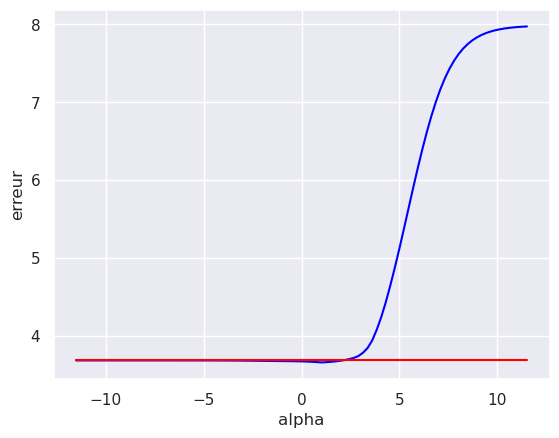

In [46]:
# On créer une liste de 100 hyperparamètres alpha régulièrement espacés entre 10^-5 et 10^5 selon une échelle logarithmique :
alphas = np.logspace(-5, 5, 100)  
                                  
coefs = []                        # Liste pour sauvegarder les coefficients des différentes régressions linéaires.
errors = []                       # Liste pour sauvegarder les erreurs des différents modèles testés.
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    coefs.append(model.coef_)
    errors.append(mean_absolute_percentage_error(y_test, y_test_pred))

sns.set(style='darkgrid')
sns.lineplot(x=np.log(alphas), y=errors, color='blue')
sns.lineplot(x=np.log(alphas), y=erreur_reference, color='red')  # Erreur de référence représentée par une barre horizontale rouge.
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.show()

Afin d'être lisible, le graphique est affiché sur une échelle logarithmique (néperienne).
On observe un léger effet positif de la régularisation Ridge qui commence aux alentours de $ \alpha = 1 $ et se termine aux alentours de $ \alpha = e^2 = 7.38 $ Nous allons maintenant afficher l'erreur minimale ainsi que la valeur de alpha pour laquelle on l'obtient :

In [47]:
erreur_minimale_ridge = errors[np.argmin(errors)]
alpha_optimal_ridge = alphas[np.argmin(errors)]

print('erreur_minimale_ridge = ', erreur_minimale_ridge)
print('alpha_optimal_ridge = ', alpha_optimal_ridge)

erreur_minimale_ridge =  3.658336714647079
alpha_optimal_ridge =  2.848035868435799


Nous allons maintenant afficher les chemins de régularisation, c'est à dire l'évolution des coefficients de régression en fonction de $\alpha$ :

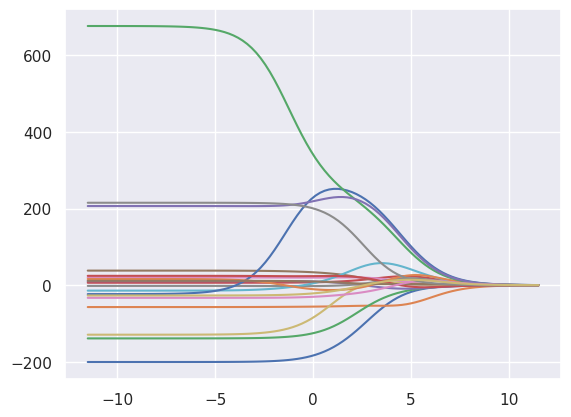

In [48]:
plt.plot(np.log(alphas), coefs)
plt.show()

#### LASSO

Passons maintenant à une régression Lasso :

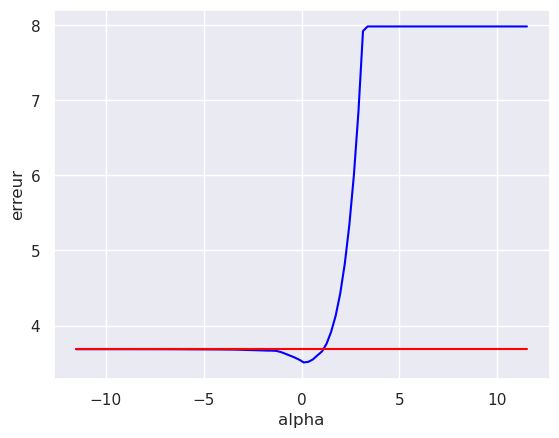

In [49]:
coefs = []
errors = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    coefs.append(model.coef_)
    errors.append(mean_absolute_percentage_error(y_test, y_test_pred))

sns.lineplot(x=np.log(alphas), y=errors, color='blue')
sns.lineplot(x=np.log(alphas), y=erreur_reference, color='red')
plt.xlabel('alpha')
plt.ylabel('erreur')
plt.show()

On observe un effet positif plus marqué de la régularisation Lasso qui démarre également aux alentours de $ \alpha = e^-1 = 0.36 $ mais fini bien plus tôt que pour le Ridge, aux alentours de $e = 2.71$. L'amplitude de la régularisation positive est donc plus petite que pour le Ridge. Affichons l'erreur minimale et le $\alpha$ optimal :

In [50]:
erreur_minimale_lasso = errors[np.argmin(errors)]
alpha_optimal_lasso = alphas[np.argmin(errors)]

print('erreur_minimale_lasso = ', erreur_minimale_lasso)
print('alpha_optimal_lasso = ', alpha_optimal_lasso)

erreur_minimale_lasso =  3.507906435526933
alpha_optimal_lasso =  1.1233240329780265


Le Lasso est ici préférable au Ridge. Les chemins de régularisation :

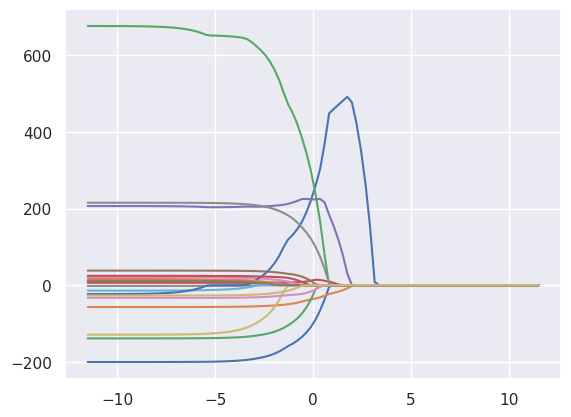

In [51]:
plt.plot(np.log(alphas), coefs)
plt.show()

On peut clairement observer ici l'effet sélectif du Lasso, qui ramène rapidement à 0 plusieurs coefficients, avant même que la valeur de $\alpha$ atteigne 1. À comparer avec les chemins du Ridge, ou pour $\alpha = 1$, pratiquement aucun coefficient est nul.

Ces trois régressions nous ont permis d'établir une ligne de comparaison pour les prochains modèles que nous entraineront sur nos données enrichies.

## 2.2. PRÉDICTION AVEC FEATURE ENGINEERING

### 2.2.1 CHARGEMENT DES DONNÉES ET ANALYSE PRÉLIMINAIRE

Commençons par charger notre dataset de prédiction enrichi :

In [52]:
data_heavy = pd.read_csv('data_heavy.csv')
data_heavy.head()

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,source_energy_epoque,energy_epoque,electricity_epoque,gaz_epoque,emissions_epoque,source_energy_type,energy_type,electricity_type,gaz_type,emissions_type
0,47,29,98101.0,7,14,47.61220,-122.33799,1927,0.693147,2.564949,...,4.837075,14.667806,13.786284,12.815810,4.020160,5.127529,15.664266,14.992125,14.762854,5.323522
1,47,29,98101.0,7,14,47.61317,-122.33393,1996,0.693147,2.484907,...,5.367843,15.682288,15.263007,14.356420,4.759821,5.127529,15.664266,14.992125,14.762854,5.323522
2,47,29,98101.0,7,14,47.61393,-122.33810,1969,0.693147,3.737670,...,4.976044,14.755308,14.086287,13.490327,3.911823,5.127529,15.664266,14.992125,14.762854,5.323522
3,47,29,98101.0,7,14,47.61412,-122.33664,1926,0.693147,2.397895,...,4.939497,14.927433,14.464058,13.187216,4.256038,5.127529,15.664266,14.992125,14.762854,5.323522
4,47,29,98121.0,7,14,47.61375,-122.34047,1980,0.693147,2.944439,...,5.131672,14.838705,14.723476,13.187377,3.926517,5.127529,15.664266,14.992125,14.762854,5.323522


In [53]:
data_heavy.shape

(1637, 35)

#### CORRÉLATIONS DES VARIABLES

Analysons les corrélations des prédicteurs deux à deux :

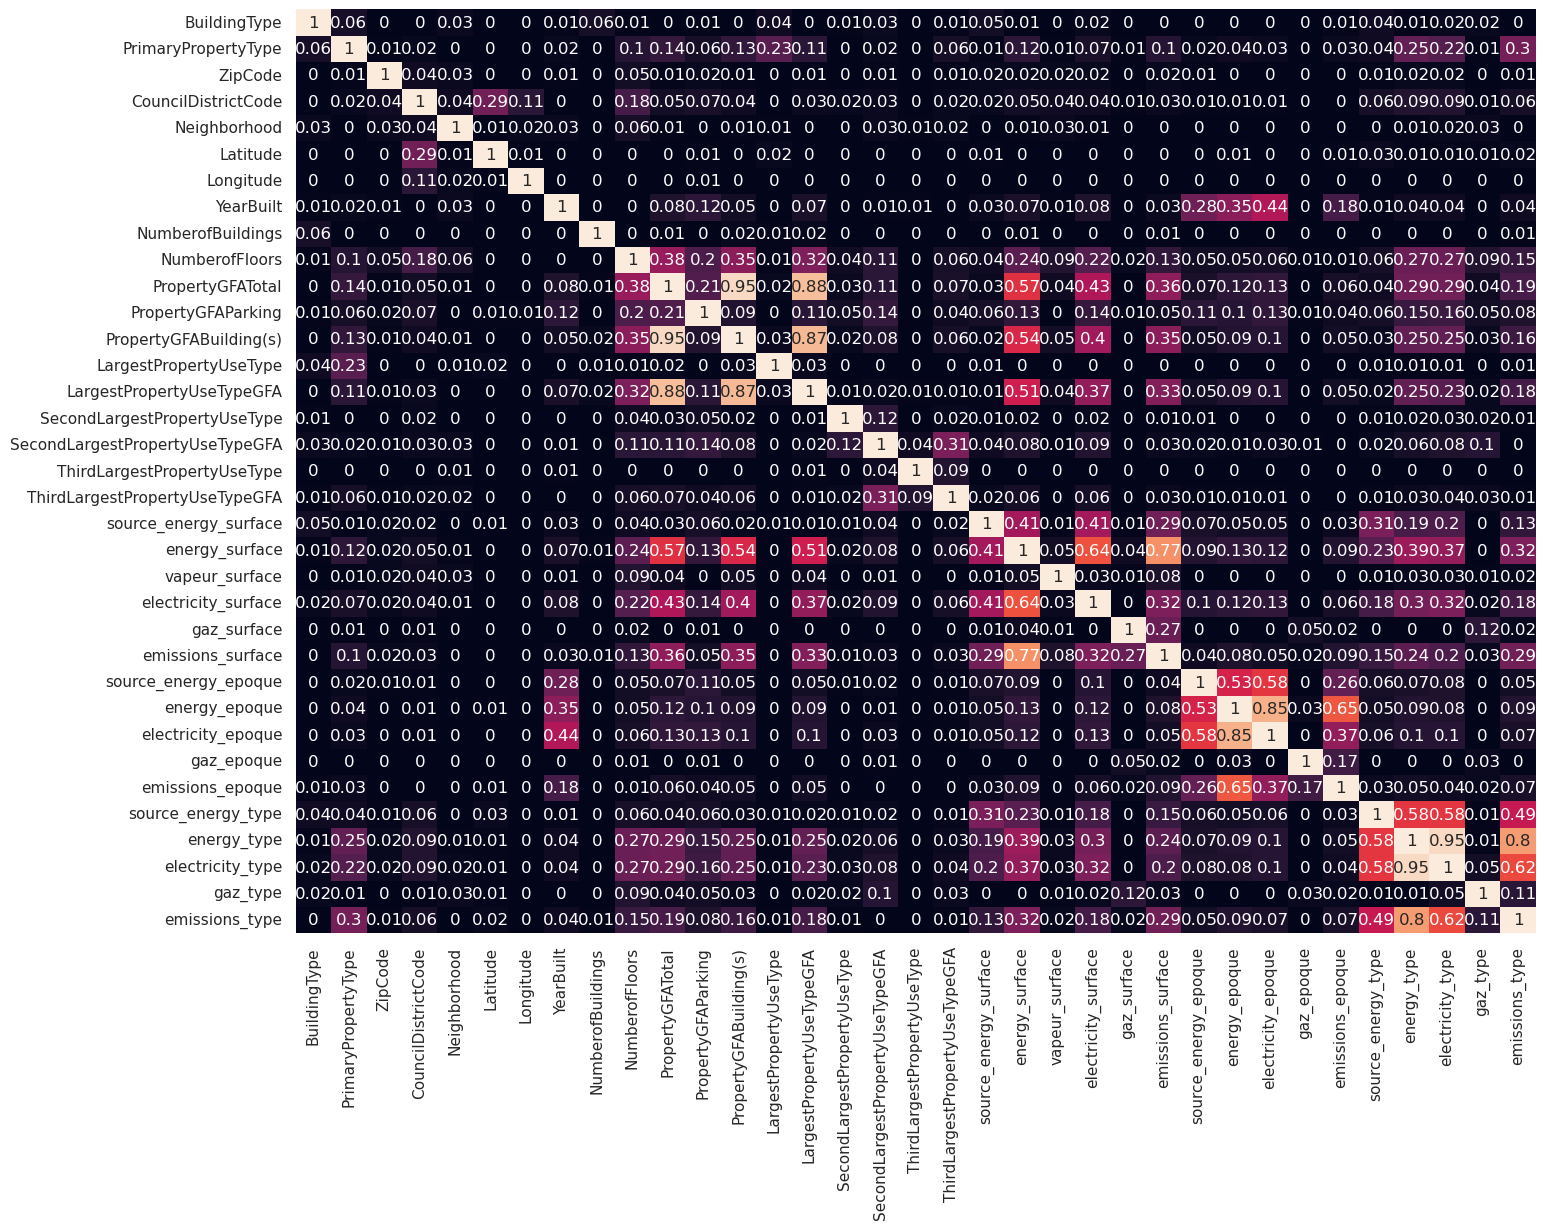

In [54]:
matrice_correlation = (data_heavy.corr()**2).round(2)

plt.figure(figsize = (16,12))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

On observe trois nouveaux groupes de variables fortement corrélées qui correspondent aux variables nouvellement ajoutées (en bas à droite). Mais il n'y pas de variables parfaitement corrélées, donc pas d'informations totalement redondantes dans le dataset.

Analysons maintenant la corrélation des prédicteurs avec la cible :

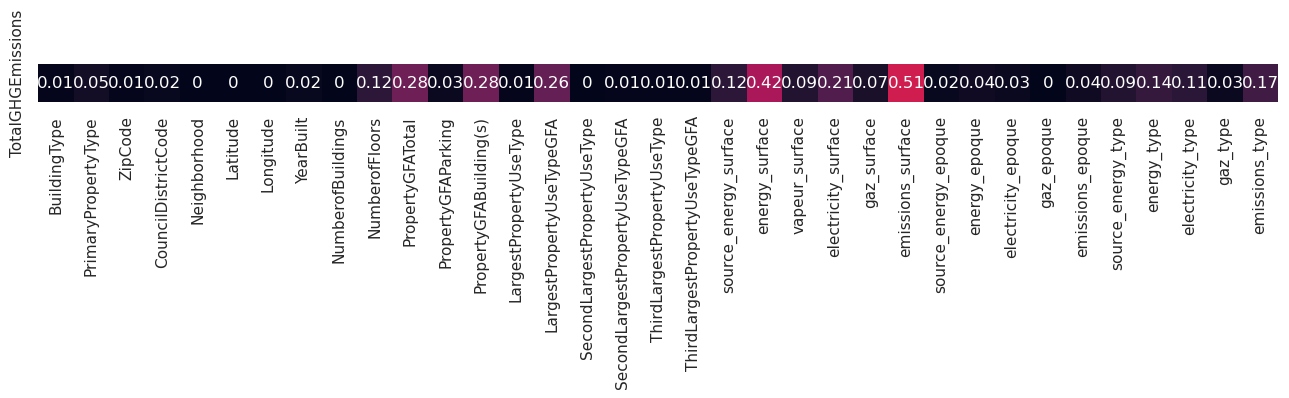

In [55]:
matrice_correlation = ((pd.concat([data_heavy, y], axis=1).corr()**2).round(2)).iloc[-1:,:-1]

plt.figure(figsize = (16,0.5))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

Parmi les nouvelles variables, il y en a quelques unes qui sont mieux corrélées à la cible que les anciennes, donc on devrait observer une meilleure performance de la régression linéaire. 

#### NORMALISATION DES PRÉDICTEURS

Normalisons les prédicteurs avec le MinMaxScaler :

In [56]:
scaled_data = scaler.fit_transform(data_heavy)
scaled_data = pd.DataFrame(scaled_data, columns=data_heavy.columns)
mt.stats_extend(scaled_data)[['min','max']]

,min,max
BuildingType,0.0,1.0
PrimaryPropertyType,0.0,1.0
ZipCode,0.0,1.0
CouncilDistrictCode,0.0,1.0
Neighborhood,0.0,1.0
Latitude,0.0,1.0
Longitude,0.0,1.0
YearBuilt,0.0,1.0
NumberofBuildings,0.0,1.0
NumberofFloors,0.0,1.0


In [57]:
X = scaled_data                # Les nouveaux prédicteurs

#### CRÉATION D'UN DATASET DE VALIDATION FINALE

Nous allons créer un dataset d'entraînement avec 75% des données et un dataset de validation pour le modèle finalement choisi avec 25% des données :

In [58]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
print(X.shape, X_val.shape)

(1227, 35) (410, 35)


### 2.2.2 MODÈLES LINÉAIRES

#### PRÉDICTION SUR LA CIBLE NON MODIFIÉE

Nous allons maintenant entraîner une régression linéaire ElasticNet. Ce modèle à deux hyperparamètres à optimiser : la constante de régularisation $\alpha$ et la part de Lasso dans la régularisation, *l1_ratio*. Afin de déterminer les hyperparamètres optimaux, nous allons mettre en place une recherche sur grille avec validation croisée à l'aide de l'outil **GridSearchCV** de la bibliothèque `scikit-learn` :

In [59]:
from sklearn.model_selection import GridSearchCV

In [60]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.logspace(-5, 5, 100),
              'l1_ratio': np.arange(0.1, 1.1, 0.1).round(1)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.236e+07, tolerance: 6.176e+03
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e+07, tolerance: 5.715e+03
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 2.2570197196339215, 'l1_ratio': 0.9}


In [61]:
alpha_optimal = 2.2570197196339215
l1_ratio_optimal = 0.9

Le meilleur modèle a un *l1_ratio* de 0.9, donc beaucoup plus proche d'un Lasso que d'un Ridge.
Testons-le et évaluons sa performance à l'aide d'une validation croisée manuelle, en utilisant l'outil **KFold** de la bibliothèque `scikit-learn` :

In [62]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [63]:
model = ElasticNet(alpha=alpha_optimal, l1_ratio=l1_ratio_optimal)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(y_train, y_train_pred))
    erreur_test.append(mean_absolute_percentage_error(y_test, y_test_pred))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 2.832354570560598
------------
erreur_test = 2.8559202276828484


On obtient une performance meilleure que précédement, mais qui reste malgré tout très insuffisante (erreur moyenne de 285% par prédiction !) 

#### PRÉDICTION SUR LA CIBLE PASSÉE AU *LOG*

Les nouveaux prédicteurs ont été passés au *log*, donc la cible passée au *log* leur est beaucoup mieux corrélée. Par conséquent, appliquer une transformation logarithmique à la cible devrait considérablement améliorer les performances de la régression linéaire. C'est ce que nous allons vérifier. Commençons par afficher la heatmap des corrélations entre les prédicteurs et la cible passée au *log* :

In [64]:
y_log = np.log(y+1)     # cible passée au log

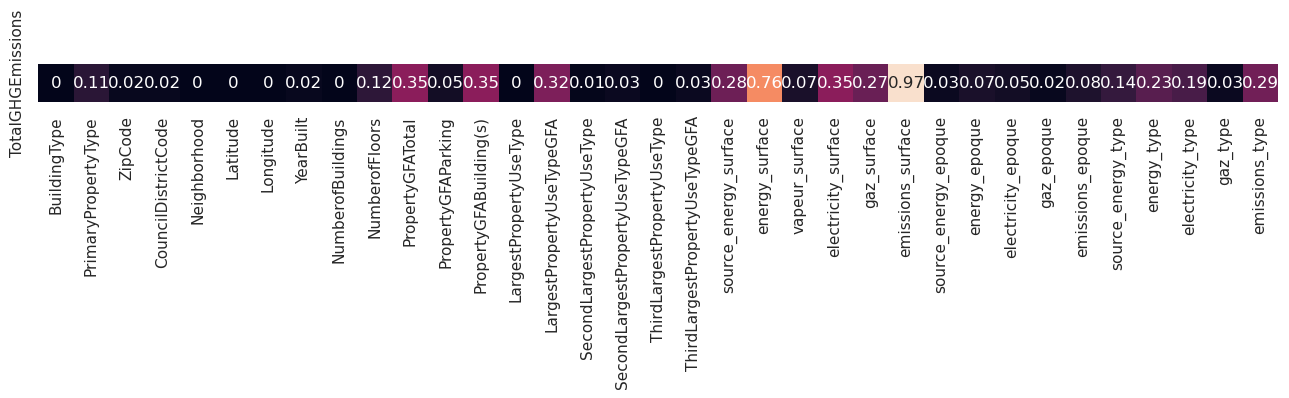

In [65]:
matrice_correlation = ((pd.concat([data_heavy, y_log], axis=1).corr()**2).round(2)).iloc[-1:,:-1]

plt.figure(figsize = (16,0.5))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

On peut effectivement observer une meilleur corrélation entre les prédicteurs et la cible. En particulier, la variable *emissions_surface* est quasi-parfaitement corrélée à la cible et devrait considérablement accroître les performances de la régression linéaire.

Nous allons à nouveau mettre en place une recherche sur grille pour trouver l'ElasticNet optimal et évaluer sa performance :

In [66]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.logspace(-5, 5, 100),
              'l1_ratio': np.arange(0.1, 1.1, 0.1).round(1)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.967e+00, tolerance: 1.951e-01
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.274e-01, tolerance: 1.936e-01
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.00210490414451202, 'l1_ratio': 1.0}


In [67]:
# Paramètres du meilleur modèle :
alpha_optimal = 0.00210490414451202
l1_ratio_optimal = 1

Cette fois, le modèle optimal est un pur Lasso. Pour évaluer correctement sa performance, il nous faut mesurer l'erreur entre la variable prédite et la cible ***toutes-deux passées à l'exponentielle***, c'est à dire mesurer l'erreur avec la cible initiale.

In [69]:
model = Lasso(alpha=alpha_optimal)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 0.1422817571362074
------------
erreur_test = 0.14431497034930157


On observe comme prévu une performance décuplée, tout à fait satisfaisante ! Par ailleurs le modèle n'*overfit* pas.

Nous allons revenir à la cible initiale pour tester des modèles plus complexes et comparer leurs performances.

### 2.2.3 MODÈLES À ARBRES

#### ARBRE DE DÉCISION

Ce modèle a un hyperparamètre fondamental qu'il va falloir optimiser : la profondeur maximale de l'arbre (max_depth).

Nous allons mettre en place une validation croisée à 5 plis et chercher l'hyperparamètre optimal à l'aide de l'outil *GridSearchCV*.

Nous allons tester ce modèle pour des profondeurs d'arbres allant de 1 à 100 :

In [70]:
from sklearn.tree import DecisionTreeRegressor

In [72]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'max_depth': range(1,101)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(DecisionTreeRegressor(),           # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 55}


Évaluons les performances du modèle trouvé :

In [73]:
model = DecisionTreeRegressor(max_depth=55, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(y_train, y_train_pred))
    erreur_test.append(mean_absolute_percentage_error(y_test, y_test_pred))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 0.0
------------
erreur_test = 0.2485431400184487


L'arbre de décision est moins performant que le Lasso précédent et overfit beaucoup. Le Lasso est donc à privilégier. On constate en tout cas que les données enrichies ont permis une amélioration considérable des performances.

#### FORÊT ALÉATOIRE

Ce modèle a deux hyperparamètres essentiels qu'il va falloir optimiser : le nombre d'estimateurs (n_estimators) et leur profondeur maximale (max_depth).

Nous allons mettre en place une validation croisée à 5 plis et chercher les hyperparamètres optimaux à l'aide de l'outil *GridSearchCV*.

Nous allons tester ce modèle pour les valeurs d'hyperparamètres suivantes :
- n_estimators : de 10 à 200, espacés de 5.
- max_depth : de 1 à 10.

In [75]:
from sklearn.ensemble import RandomForestRegressor
import time

In [47]:
debut = time.time()

# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'n_estimators': range(10,201,5),
              'max_depth': range(1,11)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(RandomForestRegressor(),           # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 10, 'n_estimators': 155}
Durée d'exécution : 1287.826683998108 secondes


Cette recherche sur grille a duré 21min27s ! Évaluons les performances du modèle trouvé :

In [76]:
debut = time.time()

model = RandomForestRegressor(n_estimators=155, max_depth=10, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(y_train, y_train_pred))
    erreur_test.append(mean_absolute_percentage_error(y_test, y_test_pred))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print('------------')
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.09113094622843484
------------
erreur_test = 0.2099318977019135
------------
Durée d'exécution : 8.425163507461548 secondes


Cette forêt aléatoire est moins performante que le Lasso et overfit un peu. Le Lasso reste préférable !

#### GRADIENT BOOST

Ce modèle a trois hyperparamètres essentiels qu'il va falloir optimiser : le taux d'apprentissage (learning_rate), le nombre d'estimateurs (n_estimators) et leur profondeur maximale (max_depth).

Nous allons à nouveau mettre en place une validation croisée à 5 plis et chercher les hyperparamètres optimaux à l'aide de l'outil *GridSearchCV*.

Nous allons tester ce modèle pour les valeurs d'hyperparamètres suivantes :
- learning_rates : de 0.1 à 1, espacés de 0.1.
- n_estimators : de 10 à 200, espacés de 5.
- max_depth : de 1 à 10.

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

In [78]:
debut = time.time()

# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'learning_rate': np.arange(0.1, 1.1, 0.1).round(1),
              'n_estimators': range(10,121,10),
              'max_depth': range(1,11)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(GradientBoostingRegressor(),       # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 50}
Durée d'exécution : 3256.6051075458527 secondes


La recherche précédente a durée 54min15s ! Évaluons les performances du modèle optimal trouvé :

In [79]:
debut = time.time()

model = GradientBoostingRegressor(learning_rate=0.3, n_estimators=50, max_depth=10, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(y_train, y_train_pred))
    erreur_test.append(mean_absolute_percentage_error(y_test, y_test_pred))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print('------------')
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.0002445170163732919
------------
erreur_test = 0.2266562287597072
------------
Durée d'exécution : 3.9378015995025635 secondes


Ce modèle est moins performant que notre Lasso et overfit beaucoup.

À ma grande surprise, le modèle gagnant est le Lasso effectué sur la cible passée au *Log* !

### 2.2.4 FINE TUNING ET VALIDATION FINALE

Nous allons à nouveau lancer une *GridSearchCV* avec des hyperparamètres à tester voisins de ceux trouvés pour l'ElasticNet précédemment :

In [80]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.arange(0.0018, 0.0031, 0.0001).round(4),
              'l1_ratio': np.arange(0.90, 1.01, 0.01).round(2)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0022, 'l1_ratio': 1.0}


Nous obtenons comme modèle final un Lasso avec un $\alpha$ de 0.022. C'est le modèle que nous retenons donc.
Nous allons à nouveau évaluer sa performance, via une validation croisée manuelle :

In [81]:
debut = time.time()

model = Lasso(alpha=0.0022)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

print('------------')
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.1423512803082268
------------
erreur_test = 0.14430441188154264
------------
Durée d'exécution : 0.04261064529418945 secondes


Le résultat est plus que satisfaisant : nous avons trouvé un modèle simple, rapide, robuste et performant !

Nous allons maintenant l'évaluer sur le dataset de validation finale :

In [82]:
y_val_pred = model.predict(X_val)

print(f"erreur = {mean_absolute_percentage_error(y_val, np.exp(y_val_pred)-1)}")

erreur = 0.20247414879828463


Résultat un peu moins bon mais qui reste satisfaisant.

Enregistrons les paramètres du modèle (coefficients de la régression) :

In [83]:
poids_lasso = model.coef_

### 2.2.5 FEATURE IMPORTANCE

Pour une régression linéaire, la contribution d'une variable dans la prédiction est donnée par la taille de son coefficient :

In [84]:
poids_lasso

array([ 0.        , -0.04301658, -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.08206572,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.02131243,  7.5220135 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.01158119,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03009335])

Ici, la plupart des coefficients sont nuls. Seules six variables contribuent à prédire la cible. Seulement il y en a une dont la contribution est écrasante : il s'agit de *emissions_surface* (qui par construction est très fortement corrélée au log de la cible, comme nous l'avons constaté plus haut). Traçons le barplot des poids des prédicteurs :

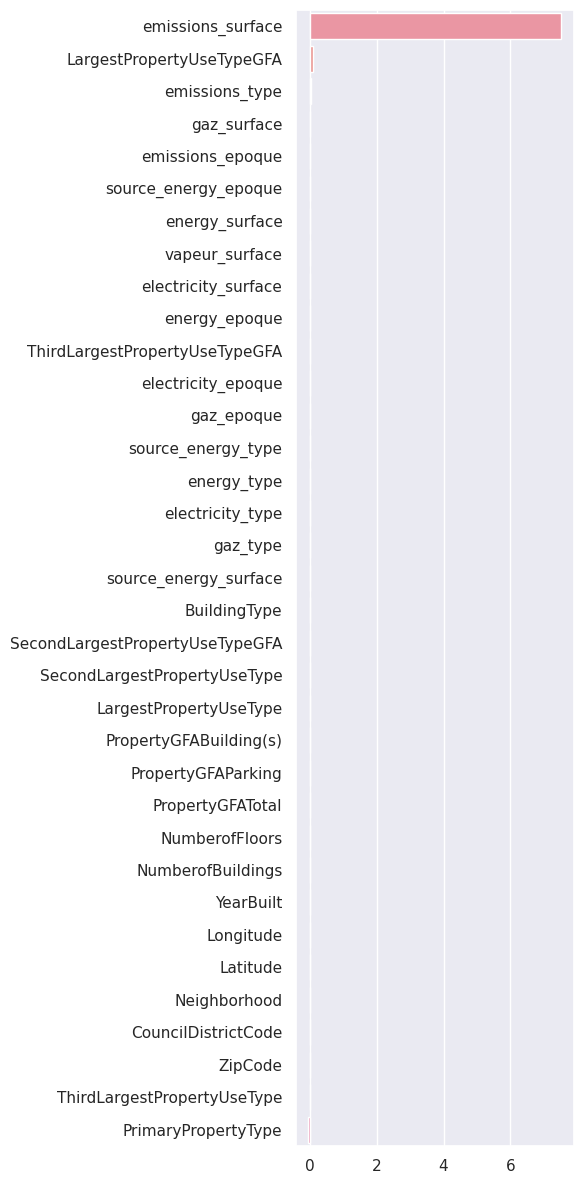

In [85]:
plt.figure(figsize=(6,12))
coefs = pd.DataFrame(poids_lasso, index=data_heavy.columns).sort_values(by=0, ascending=False).T
sns.barplot(data = coefs, orient='h')
plt.tight_layout()
plt.show()

Sans commentaire. Il est inutile ici d'utiliser la librairie Shap pour faire une analyse de Feature importance pour ce modèle. Mais nous l'utiliserons plus loin seulement pour illustrer son utilisation.

Nous allons maintenant évaluer l' **ENERGYSTARScore**. Nous allons l'ajouter comme prédicteur au dataset d'entraînement et voir s'il améliore les performances de prédiction de façon notable.

In [86]:
data_heavy['ENERGYSTARScore'] = data.ENERGYSTARScore

On normalise les prédicteurs :

In [87]:
scaled_data = scaler.fit_transform(data_heavy)

In [88]:
X = pd.DataFrame(scaled_data, columns=data_heavy.columns)
y = np.log(data.TotalGHGEmissions)

On lance l'évaluation de performance avec validation croisée à 5 plis :

In [89]:
debut = time.time()

model = Lasso(alpha=0.0028)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

print('------------')
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.3427902714625419
------------
erreur_test = 0.3444383195239821
------------
Durée d'exécution : 0.05095338821411133 secondes


On observe aucune amélioration des performances avec l'ajout de l'*ENERGYSTARScore* comme prédicteur. On constate plutôt une dégradation des performances. Nous allons analyser l'influence de chaque prédicteur à l'aide de la libraire Shap : 

In [90]:
import shap

shap.initjs() # Initialisation de JavaScript pour pouvoir tracer des graphiques avec Shap

In [91]:
explainer = shap.LinearExplainer(model, X_test)

In [92]:
# Calcul des valeurs SHAP pour toutes les observations de l'ensemble de test (le dernier)
shap_values = explainer.shap_values(X_test)

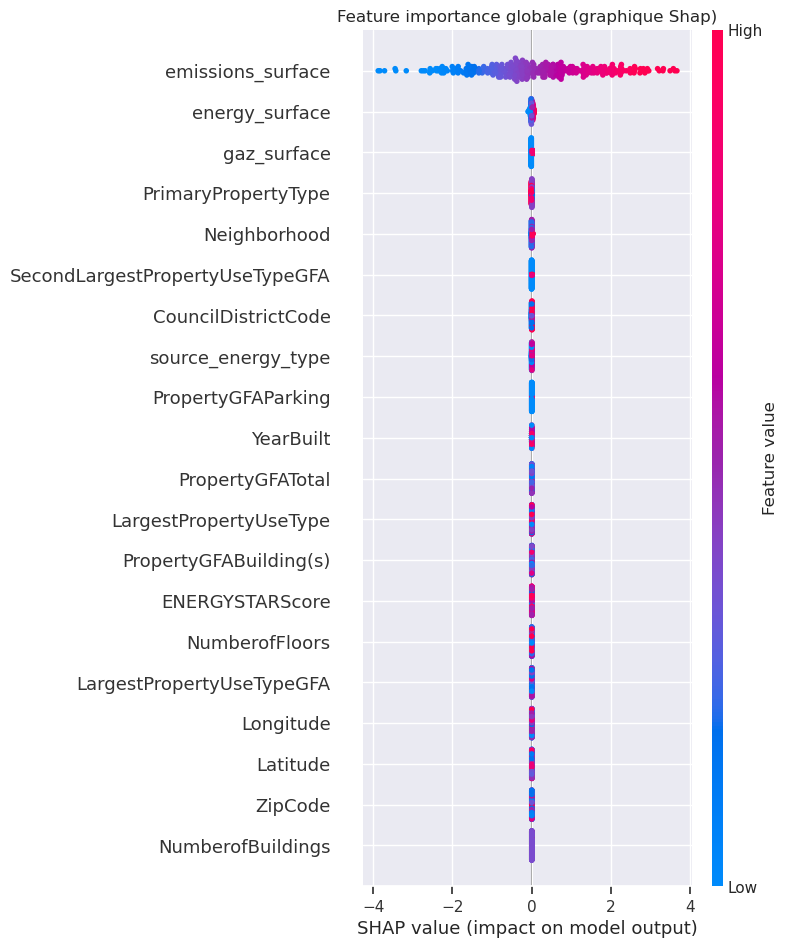

In [93]:
# Résumé global de l'importance des caractéristiques (graphique Shap):
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title('Feature importance globale (graphique Shap)')
plt.show()

On voit bien que l'*ENERGYSTARScore* n'a (pratiquement) aucune influence dans la prédiction. ***Cette feature est donc inutile pour prédire la quantité de CO2 émise***.

Passons maintenant à l'analyse de feature importance locale, c'est à dire pour chaque prédiction donnée.

In [94]:
observation_index = range(200)
x_observation = X_test.iloc[observation_index]

# Force plot pour les observations sélectionnées
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index, :], x_observation)

Nous avons sélectionné ici les 200 premières observations (propriétés) de l'ensemble de test. Quelques explications sur le fonctionnement de ce graphique interactif :
- Les observations sont représentées par l'axe horizontal et leur valeurs prédites sont représentées par l'axe vetical ;
- Les observations sont ici rangées dans l'ordre croissant de leurs valeurs prédites (On peut choisir un autre ordre) ;
- La valeur centrale de l'axe vertical représente la moyenne des valeurs prédites et ces dernières s'étendent de -0.112 à 7.488.
- Tout à gauche, on peut sélectionner la variable dont ont souhaite analyser la contribution dans la prédiction : f(x) représente la contribution de l'ensemble des prédicteurs ;
- Pour un prédicteur et une observation donnés :
      1) Si la valeur prédite est inférieure à la moyenne, une coloration bleu indique une contribution positive de ce prédicteur pour cette observation et une coloration rouge indique une contribution négative.
      2) Si la valeur prédite est supérieure ou égale à la moyenne, c'est l'inverse.

On peut maintenant faire les constatations suivantes :
- On retrouve la contribution écrasante de la variable *emissions_surface* : son graphique se confond presque avec celui de l'ensemble des prédicteurs f(x).
- Cette variable contribue toujours de façon positive.
- En choisissant l'*ENERGYSTARScore* dans la liste des prédicteurs à gauche, on peut voir son absence totale de contribution. À comparer par exemple avec la variable *PrimaryPropertyType* qui, bien que de contribution faible (l'amplitude de ses valeurs prédites est très faible devant celle des valeurs prédites globales), contribue quand même de façon perceptible, tantôt positivement, tantôt négativement.

En fait, le Lasso fonctionne ainsi : Il prend la valeur de *emissions_surface* comme valeur de référence pour la prédiction. Il *sélectionne* ensuite quelques autres prédicteurs assez bien corrélés à la cible pour corriger cette valeur de référence et la rapprocher de la valeur cible réelle.

In [95]:
observation_index = range(1)
x_observation = X_test.iloc[observation_index]

# Force plot pour l'observation sélectionnée
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index, :], x_observation)

Ce graphique représente une tranche verticale du graphique précédent, pour la première observation de l'ensemble de test ici. La valeur prédite pour cette observation est de 5.69 et on voit à nouveau ici la contribution positive écrasante du prédicteur *emissions_surface* pour cette prédiction.

In [98]:
observation_index = 32
x_observation = X_test.iloc[observation_index]

# Force plot pour l'observation sélectionnée
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index, :], x_observation)

Encore un graphique d'importance locale, pour la 33e observation de l'ensemble de test ici. La valeur prédite pour cette observation est de 3.7 et on voit encore ici la contribution positive dominante du prédicteur *emissions_surface* pour cette prédiction. D'autres prédicteurs contribuent de façon non négligeable :
- Les prédicteurs *energy_surface*, *gaz_surface*, *PrimaryPropertyType* et *Neighborhood* contribuent positivement ;
- Le prédicteur *ConcilDistrictCode*, négativement. 